In [ ]:
from  google.colab import drive  
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/algo trading/stocks
### save and load data using pickle
import pickle
def psave(dataframe, fname):
    with open('{}.pkl'.format(fname),'wb') as pickle_file:
        pickle.dump(dataframe,pickle_file)
        
def pload(fname):
  
  with open('{}.pkl'.format(fname),'rb') as pickle_file:
      dataframe=pickle.load(pickle_file)
      return dataframe
%reload_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/algo trading/stocks


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import sys

In [ ]:
sys.path.append("/content/drive/MyDrive/Colab Notebooks/")
%reload_ext autoreload
%autoreload 2


In [ ]:
from trading_main import account
from DfPlot import dp

In [ ]:
def Stationarity(x,cutoff=0.01): 
  pvalue=adfuller(x)[1]
  if pvalue<cutoff:
    print('p-value='+str(pvalue)+' The series '+'is likely stationary')
    return 1
  else:
    print('p-value='+str(pvalue)+' The series '+'is likely non-stationary')
    return 0

In [ ]:
temp=pload('2015_3_30StockData')

In [ ]:
StockData={}
for a in temp:
  if temp[a].shape[0]==1513:
    StockData[a]=temp[a]

In [ ]:
print(len(StockData.keys()))

987


In [ ]:
split=int(1513*0.6)


In [ ]:
a=pload('PooledPairsPvalueSorted')
print(a.shape[0])

11747


In [ ]:
def GetName(names,df,i):
  return [names[a.iloc[i]['index'][0]],names[a.iloc[i]['index'][1]]]

def GetData(StockData,names,df,i,value='Adj Close'):
  return [StockData[names[a.iloc[i]['index'][0]]][value],StockData[names[a.iloc[i]['index'][1]]][value]]

In [ ]:
egindex=161
names=list(StockData.keys())
for i in [egindex]:
  print(names[a.iloc[i]['index'][0]],names[a.iloc[i]['index'][1]])

QUMU KMDA


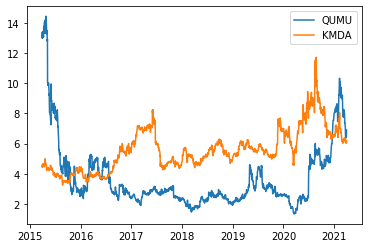

In [ ]:
dp.DfPlot(GetData(StockData,names,a,egindex),GetName(names,a,egindex),listofxvlines=[])

In [ ]:
def RollingOLSBeta(lag,Y,X):
  betas=[]
  for i in range(lag,X.shape[0]):

    XC=sm.add_constant(X)
    model = sm.OLS(Y.iloc[i-lag:i],XC[i-lag:i])
    results = model.fit()
    beta=results.params[1]
    betas.append(beta)
  return np.array(betas)


Date
2015-03-30   -8.47
2015-03-31   -8.98
2015-04-01   -8.43
2015-04-02   -8.56
2015-04-06   -8.74
              ... 
2021-03-25   -0.23
2021-03-26   -0.56
2021-03-29   -0.36
2021-03-30   -0.71
2021-03-31   -0.70
Name: Adj Close, Length: 1513, dtype: float64


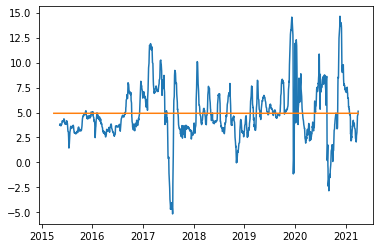

In [ ]:
X,Y = GetData(StockData,names,a,egindex)
actualspread=Y-X
egname=GetName(names,a,egindex)
lag=30
betas=RollingOLSBeta(30,Y,X)

spread=Y[lag:]-betas*X.iloc[lag:]
mean=np.mean(spread)
plt.plot(X.iloc[lag:].index,spread)
plt.plot(X.index,np.ones(X.shape[0])*mean)
print(actualspread)

p-value=0.0012086566708123141 The series is likely stationary


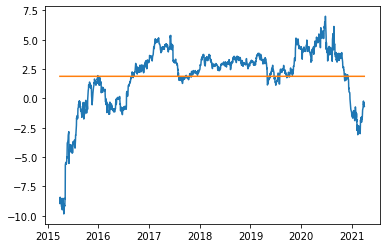

In [ ]:
Stationarity(Y-X)
mean=np.mean(Y-X)
plt.plot(X.index,Y-X)

plt.plot(X.index,np.ones(X.shape[0])*mean)

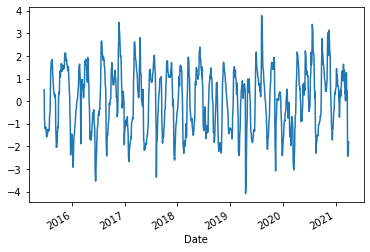

In [ ]:
std_30=spread.rolling(30).std()
mean_30=spread.rolling(30).mean()
zscore_30_1=(spread-mean_30)/std_30
zscore_30_1.plot()

In [ ]:
testrunData={}
for i in [0,1]:
  name=egname[i]
  d=GetData(StockData,names,a,egindex)[i]
  testrunData[name]=d

In [ ]:
d.iloc[split:].index[0]

Timestamp('2018-11-01 00:00:00')

In [ ]:
split=int(1513*0.6)
testrunAccount=account(10000,d.iloc[split:].index[0],testrunData)

In [ ]:
def CrossThreshold(thre,series,time,yestertime):
  a=series.loc[time]
  b=series.loc[yestertime]
  if (a-thre)*(b-thre)<0:
    return 1
  else:
    return 0

In [ ]:
def strategy1(acc,zscore,enddate,name,longsig,shortsig,exitsig,portion):
  i=[0]
  stratRecord=[]
  stocks,money=acc.CheckAccount()
  while enddate>=acc.CheckDate():
    stocks,money=acc.CheckAccount()
    date=acc.CheckDate()
    Xprice=acc.CheckCurrentValue(name[0],'Adj Close')
    Yprice=acc.CheckCurrentValue(name[1],'Adj Close')
    Xvolume=min(int(portion*money/Xprice),int(portion*money/Yprice))
    Yvolume=Xvolume
    if len(i)!=1 and i[-1]!=0:
        if CrossThreshold(exitsig,zscore,date,acc.CheckDate(-1))==1 or zscore[date]==exitsig:
          stratRecord.append('Clear')
          acc.Clear()
          i.append(0)
          stocks,money=acc.CheckAccount()
          totalAsset=acc.TotalAsset()
          
    if Xvolume>0 and Yvolume>0:
      
      if zscore.loc[date]>shortsig and i[-1]==0:
        stratRecord.append('Short')
        acc.Sell(name[0],Yvolume)
        acc.Buy(name[1],Xvolume)
        i.append(1)
        stocks,money=acc.CheckAccount()
        totalAsset=acc.TotalAsset()
        
      if zscore.loc[date]<longsig and i[-1]==0:
        stratRecord.append('Long')
        acc.Sell(name[1],Xvolume)
        acc.Buy(name[0],Yvolume)
        i.append(2)
        money=acc.CheckMoney()
        totalAsset=acc.TotalAsset()
        
    
    
    acc.IncementDay()
  
  acc.Clear()
  stratRecord.append('Clear')
  stocks,money=acc.CheckAccount()
  print('!',acc.stocks)
  totalAsset=acc.TotalAsset()
  print(totalAsset,money)
  return acc,stratRecord


In [ ]:
import math as mt
start=d.iloc[split:].index[0]
testrunAccount=account(10000,start,testrunData,PrintRecord=True)
end=d.iloc[split:].index[0]+datetime.timedelta(days=260)
b,stratRecord=strategy1(testrunAccount,zscore_30_1,end,egname,-1.5,1.5,0,0.5)

2018-11-01 00:00:00 Sold 218 shares of TSEM stock at price 16.450000762939453
2018-11-01 00:00:00 Bought 218 shares of SSYS stock at price 22.850000381469727
2018-11-08T00:00:00.000000000 Bought 218 shares of TSEM stock at price 15.479999542236328
2018-11-08T00:00:00.000000000 Sold 218 shares of SSYS stock at price 24.309999465942383
2018-11-14T00:00:00.000000000 Sold 237 shares of SSYS stock at price 22.149999618530273
2018-11-14T00:00:00.000000000 Bought 237 shares of TSEM stock at price 14.789999961853027
2018-12-11T00:00:00.000000000 Sold 237 shares of TSEM stock at price 15.359999656677246
2018-12-11T00:00:00.000000000 Bought 237 shares of SSYS stock at price 20.299999237060547
2019-01-15T00:00:00.000000000 Sold 262 shares of TSEM stock at price 14.550000190734863
2019-01-15T00:00:00.000000000 Bought 262 shares of SSYS stock at price 21.139999389648438
2019-01-23T00:00:00.000000000 Bought 262 shares of TSEM stock at price 13.989999771118164
2019-01-23T00:00:00.000000000 Sold 262 s

In [ ]:
r=b.ShowTradeRecord()

In [ ]:
g=r['time'].unique()
print(len(g),len(stratRecord))
colors=['g','m','r','y','k','w']
colorDic={}
j=0
for i in set(stratRecord):
  colorDic[i]=colors[j]
  j+=1


16 16


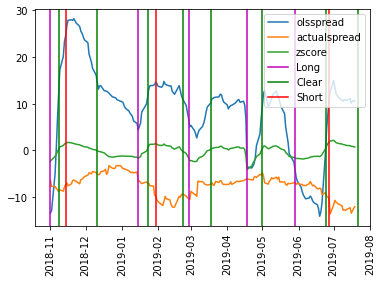

         time Buy|Sell stock      price volume         money         asset
0  2018-11-01     Sell  TSEM  16.450001   -218  13586.100166  10000.000000
1  2018-11-01      Buy  SSYS  22.850000    218   8604.800083  10000.000000
2  2018-11-08      Buy  TSEM  15.480000    218   5230.160183  10529.740067
3  2018-11-08     Sell  SSYS  24.309999   -218  10529.740067  10529.740067
4  2018-11-14     Sell  SSYS  22.150000   -237  15779.289976  10529.740067
5  2018-11-14      Buy  TSEM  14.790000    237  12274.059985  10529.740067
6  2018-12-11     Sell  TSEM  15.360000   -237  15914.379904  11103.280085
7  2018-12-11      Buy  SSYS  20.299999    237  11103.280085  11103.280085
8  2019-01-15     Sell  TSEM  14.550000   -262  14915.380135  11103.280085
9  2019-01-15      Buy  SSYS  21.139999    262   9376.700294  11103.280085
10 2019-01-23      Buy  TSEM  13.990000    262   5711.320354  11226.420155
11 2019-01-23     Sell  SSYS  21.049999   -262  11226.420155  11226.420155
12 2019-01-30     Sell  S

In [ ]:
dp.DfPlot([spread,actualspread,zscore_30_1],['olsspread','actualspread','zscore'],start=start,end=end,xvline=True,listofxvlines=g,
          xvColor=True,xvColorDic=colorDic,xvColorIndex=stratRecord)
print(r)

In [ ]:
def hurst(self, ts):
        """
        Returns the Hurst Exponent of the time series vector ts.
        Series vector ts should be a price series.
        Source: https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing"""
        # Create the range of lag values
        lags = range(2, 100)

        # Calculate the array of the variances of the lagged differences
        # Here it calculates the variances, but why it uses
        # standard deviation and then make a root of it?
        tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

        # Use a linear fit to estimate the Hurst Exponent
        poly = np.polyfit(np.log(lags), np.log(tau), 1)

        # Return the Hurst exponent from the polyfit output
        return poly[0] * 2.0